# **stackingを試してみる**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import math
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def add_time_sincos(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data['year'] = input_data['datetime'].map(lambda x: int(x.year))
    input_data = input_data.drop(['hour', 'month', 'minute'], axis=1)
    return input_data

In [4]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [5]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [6]:
-

In [7]:
def to_zero(prediction):
    '''
    2012年から2015年の間で一度も発電量がなかった時間帯を0と予測するようにする
    '''
    mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,0,0,0,0,0,0,0,0,0,0])
    all_mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,0,0,0,0,0,0,0,0,0,0])
    length = int(len(prediction)/48)
    
    for i in range(length-1):
        all_mask = np.r_[all_mask, mask]
    
    return prediction * all_mask

In [8]:
def to_zero_df(train_prediction):
    '''
    発電しない時間帯を全て0にする
    '''
    for column in train_prediction.columns[1:]:
        tmp = train_prediction[column]
        tmp = np.array(tmp)
        tmp = to_zero(tmp)
        train_prediction[column] = tmp
    return train_prediction

In [9]:
def minus_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

In [10]:
n_estimators = 20
max_depth = 5
max_features = "sqrt"

In [11]:
# 発電量データ
all_output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
all_output_30['datetime'] = all_output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **ランダムフォレスト**

### **浮島発電所について**

In [12]:
target_place = 1

In [13]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [15]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [16]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [17]:
len(train_prediction.columns), len(test_prediction.columns)

(39, 39)

In [18]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [19]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [20]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

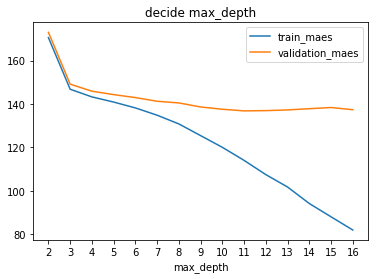

In [21]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [22]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [23]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 11, max_features=max_features)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i += 1
    train_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(all_X)
    predict_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

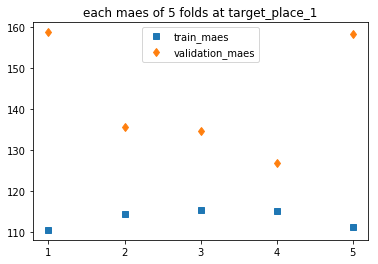

In [24]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [25]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **扇島発電所について**

In [26]:
target_place = 2

In [27]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [29]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [30]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [31]:
len(train_prediction.columns), len(test_prediction.columns)

(39, 39)

In [32]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [33]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [34]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

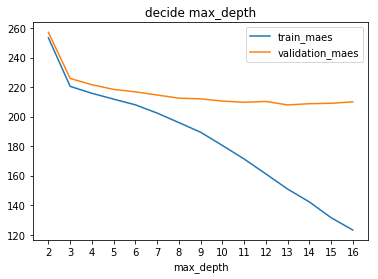

In [35]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [36]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [37]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 10, max_features=max_features)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i += 1
    train_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(all_X)
    predict_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

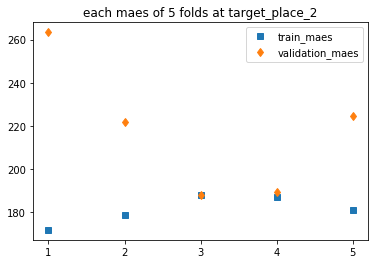

In [38]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [39]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **米倉山発電所について**

In [40]:
target_place = 3

In [41]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [43]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [44]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [45]:
len(train_prediction.columns), len(test_prediction.columns)

(39, 39)

In [46]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [47]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [48]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

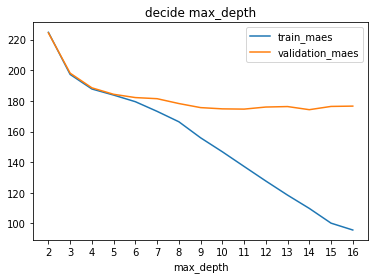

In [49]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [50]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [51]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 10, max_features=max_features)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i += 1
    train_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(all_X)
    predict_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

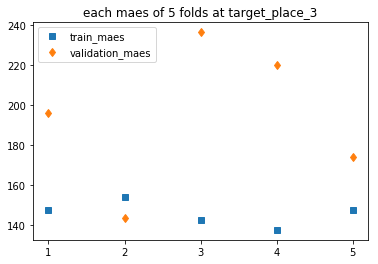

In [52]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [53]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### 線形モデルでやってみる

In [54]:
from sklearn import linear_model

### **浮島**

In [55]:
target_place = 1

In [56]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [58]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [59]:
len(train_prediction.columns), len(test_prediction.columns)

(34, 34)

In [60]:
# 月,時間ダミーを入れてみてもいいかも
'''
train_prediction["month"] = train_prediction["datetime"].map(lambda x :str(x.month))
train_prediction["hour"] = train_prediction["datetime"].map(lambda x : str(x.hour))
test_prediction["month"] = test_prediction["datetime"].map(lambda x :str(x.month))
test_prediction["hour"] = test_prediction["datetime"].map(lambda x :str(x.hour))

train_prediction =pd.get_dummies(train_prediction)
test_prediction =pd.get_dummies(test_prediction)
'''

print()

In [61]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [62]:
X, Y = drop_nan(X, Y)
X = np.array(X)
Y = np.array(Y)

In [63]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [64]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    lin_model = linear_model.LinearRegression(fit_intercept=False)
    lin_model.fit(X_train, Y_train)
    Y_train_pred = lin_model.predict(X_train)
    Y_val_pred = lin_model.predict(X_val)
    
    i += 1
    train_data["linear_regression_"+str(i)+"-"+str(n_splits)+"folds"] = lin_model.predict(all_X)
    predict_data["linear_regression_"+str(i)+"-"+str(n_splits)+"folds"] = lin_model.predict(X_test)

    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


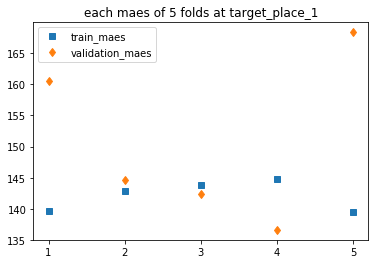

In [65]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [66]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **扇島**

In [67]:
target_place = 2

In [68]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [70]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [71]:
len(train_prediction.columns), len(test_prediction.columns)

(34, 34)

In [72]:
# 月,時間ダミーを入れてみてもいいかも
'''
train_prediction["month"] = train_prediction["datetime"].map(lambda x :str(x.month))
train_prediction["hour"] = train_prediction["datetime"].map(lambda x : str(x.hour))
test_prediction["month"] = test_prediction["datetime"].map(lambda x :str(x.month))
test_prediction["hour"] = test_prediction["datetime"].map(lambda x :str(x.hour))

train_prediction =pd.get_dummies(train_prediction)
test_prediction =pd.get_dummies(test_prediction)
'''

print()

In [73]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [74]:
X, Y = drop_nan(X, Y)
X = np.array(X)
Y = np.array(Y)

In [75]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [76]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    lin_model = linear_model.LinearRegression(fit_intercept=False)
    lin_model.fit(X_train, Y_train)
    Y_train_pred = lin_model.predict(X_train)
    Y_val_pred = lin_model.predict(X_val)
    
    i += 1
    train_data["linear_regression_"+str(i)+"-"+str(n_splits)+"folds"] = lin_model.predict(all_X)
    predict_data["linear_regression_"+str(i)+"-"+str(n_splits)+"folds"] = lin_model.predict(X_test)

    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

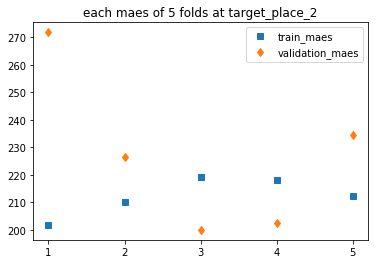

In [77]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [78]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **米倉山**

In [79]:
target_place = 3

In [80]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [82]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [83]:
len(train_prediction.columns), len(test_prediction.columns)

(34, 34)

In [84]:
# 月,時間ダミーを入れてみてもいいかも
'''
train_prediction["month"] = train_prediction["datetime"].map(lambda x :str(x.month))
train_prediction["hour"] = train_prediction["datetime"].map(lambda x : str(x.hour))
test_prediction["month"] = test_prediction["datetime"].map(lambda x :str(x.month))
test_prediction["hour"] = test_prediction["datetime"].map(lambda x :str(x.hour))

train_prediction =pd.get_dummies(train_prediction)
test_prediction =pd.get_dummies(test_prediction)
'''

print()

In [85]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [86]:
X, Y = drop_nan(X, Y)
X = np.array(X)
Y = np.array(Y)

In [87]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [88]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    lin_model = linear_model.LinearRegression(fit_intercept=False)
    lin_model.fit(X_train, Y_train)
    Y_train_pred = lin_model.predict(X_train)
    Y_val_pred = lin_model.predict(X_val)
    
    i += 1
    train_data["linear_regression_"+str(i)+"-"+str(n_splits)+"folds"] = lin_model.predict(all_X)
    predict_data["linear_regression_"+str(i)+"-"+str(n_splits)+"folds"] = lin_model.predict(X_test)

    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

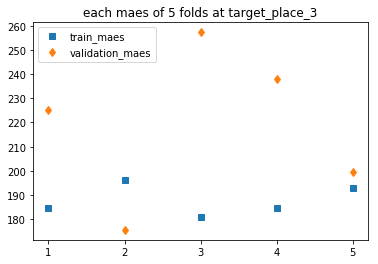

In [89]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [90]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **線形モデル(PLS)をつかう**

In [91]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

### **浮島**

In [92]:
target_place = 1

In [93]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [94]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [95]:
len(train_prediction.columns), len(test_prediction.columns)

(34, 34)

In [96]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [97]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [98]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)

In [99]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [100]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    
    i += 1
    train_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(all_X))
    predict_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(X_test))
    
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

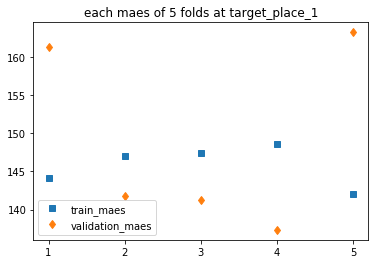

In [101]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [102]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **扇島**

In [103]:
target_place = 2

In [104]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [106]:
len(train_prediction.columns), len(test_prediction.columns)

(34, 34)

In [107]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [108]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [109]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)

In [110]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [111]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    
    i += 1
    train_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(all_X))
    predict_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(X_test))
    
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

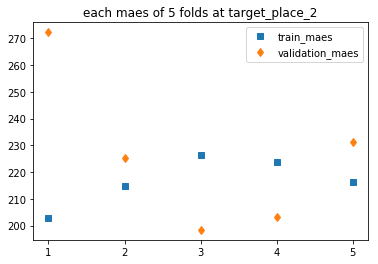

In [112]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [113]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **米倉山**

In [114]:
target_place = 3

In [115]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [116]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [117]:
len(train_prediction.columns), len(test_prediction.columns)

(34, 34)

In [118]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [119]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [120]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)

In [121]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [122]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    
    i += 1
    train_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(all_X))
    predict_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(X_test))
    
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

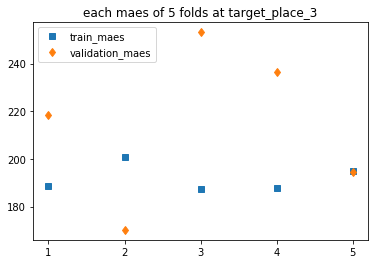

In [123]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [124]:
predict_data.to_csv('data/predicted_data/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/predicted_data/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)